In [1]:
# Python packages for basic data manipulation
import pandas as pd
import numpy as np
import os
# for Bayesian modeling 
import pymc as pm
import arviz as az
# and for plotting
from matplotlib import pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
# set some default plotting params
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']
plt.rcParams.update({'font.size': 12})

In [2]:
# load data from file 
fpath = os.path.join('experiment1', 'data.tsv')
df = pd.read_csv(fpath, sep = '\t')
df.iloc[:,:8].head() # preview the data

,subject,control_A1,control_A2,correct_A,control_B1,control_B2,correct_B,more_certain
0,0,0.079935,0.179775,1,0.109114,0.071267,0,A
1,0,0.119088,0.074623,1,0.171798,0.045486,1,B
2,0,0.065143,0.048692,0,0.141877,0.119812,1,B
3,0,0.130204,0.195408,1,0.155187,0.108303,1,B
4,0,0.150037,0.074226,0,0.111348,0.058685,0,A


## Background

The core assumption of a psychophysical scaling model is that a stimulus of level $S$ elicits a mean internal/mental/neural/whatever response of magnitude $R = f(S) + \epsilon$, where $\epsilon$ is a noise term. The goal of the model is to approximate the function $f$. 

There are multiple approaches to measuring such internal responses. One is to elicit absolute magnitude ratings directly (e.g. on a self-report scale); mean ratings as a function of stimulus level often follow [Steven's power law](https://en.wikipedia.org/wiki/Stevens%27s_power_law), $f(S) = kS^\alpha$. Depending on the power law exponent $\alpha$, scaling can be compressive/concave ($\alpha < 1$) like pitch = $f$(frequency), expansive/convex ($\alpha > 1$) like pain perception, or linear ($\alpha = 1$) like perceived length. 

Another approach is to fit a function $\hat{f}$ such that $\hat{f}(S_1) - \hat{f}(S_2)$ is proportional to the subjects' ability to discriminate between $S_1$ and $S_2$. A big advantage of this approach is that it is (probably) much easier for a person to report pairwise judgments (e.g. which of two stimuli is larger, or are these two stimuli different) than it is for them to turn their subjective experience into a number. In that sense, scaling functions estimated in this manner are arguably more "objective" than direct ratings of stimulus magnitude. 

A disadvantage is that discriminability isn't just a function of $f(S_1) - f(S_2)$ but of $[f(S_1) + \epsilon_1] - [f(S_2) + \epsilon_2]$. Thus, $\hat{f}$ estimated this way will only approximate the "true" $f$ if $\epsilon$ is uncorrelated with $S$. [Zhou et al. (2024)](https://doi.org/10.1073/pnas.2312293121) recently demonstrated quite elegantly that $\hat{f}$ can be concave even if $f$ is actually convex as long as the variance of $\epsilon$ scales in proportion to $f(S)$ (which is actually expected for the neural "rate codes" often observed in the brain); this deceptively simple result is actually quite important, as it has long vexed perceptual psychologists that $\hat{f}$ estimates fit from discrimination tasks almost always yield scaling functions that increase concavely with increasing values of $S$, said to follow the [Weber–Fechner laws](https://en.wikipedia.org/wiki/Weber%E2%80%93Fechner_law), even if direct-report scales for the same $S$ follow Stevens's law with $\alpha > 1$. Weber's law states that the amount you'd need to change a stimulus for a subject to detect a change is proportional to the level of that stimulus; Fechner's law is just a form of psychometric function that satisfies that property, which is always concave. 

Estimates $\hat{f}$ _can_ be convex, but only if you have the direction of $S$ backward. That's what we're testing here. The motor control literature has long [linked prediction error and control](https://doi.org/10.1038/2870); we can better predict stimuli that we control, so lack of sensorimotor error is a decent proxy for controllability. In other words, it is possible that control and error are two ends of the same spectrum, and we need not have seperate representations for the two. In the case that there exists one, shared representation and that representation is of error, then $\hat{f}$(error) should be a concave function, which would make $\hat{f}$(control) convex -- or vice versa, if the internal representation is of control, not error. If there are seperate representations of control and of error, then both $\hat{f}$(control) and  $\hat{f}$(error) can be concave at the same time. 

## Our model

Okay, so let's get into the specification of our specific model. 

On each trial, we first show subjects two stimuli of levels $S_a$ and $S_b$ and we ask them to report which they have more control over. (Movements of the stimuli are a mixture of subjects' mouse movements and of a random trajectory, with mixture proportion, i.e. "control level" randomly set for each stimulus.) We then ask them to do the same for two more stimuli $S_c$ and $S_d$. We assume that subjects have a noisy internal response to the stimulus with mean $\mu = f(S) = kS^\alpha$ and noise $\epsilon \sim N(0, 1)$:

$$
\begin{aligned}
R_a &= \mu_a + \epsilon = kS_a^\alpha + \epsilon \\ 
R_b &= \mu_b + \epsilon = kS_b^\alpha + \epsilon \\ 
R_c &= \mu_c + \epsilon = kS_c^\alpha + \epsilon \\ 
R_d &= \mu_d + \epsilon = kS_a^\alpha + \epsilon \\ 
\end{aligned}
$$

We assume subjects will respond that $S_b > S_a$ if $R_b > R_a$ and so on. 

Since the variance of $\epsilon$ is fixed to 1, we can say that $R_a \sim N(\mu_a, 1)$, etc., and by the properties of the normal distribution, $R_b - R_a \sim N(\mu_b - \mu_a, \sqrt{2})$ as is $R_d - R_c$. Thus, given parameters $\alpha$ and $k$, we can calculate the probability that $R_b - R_a > 0$ for any $S_a$ and $S_b$. That gives us the Binomial likelihood of subjects' pairwise judgment response given the parameters we're trying to fit $\alpha, k$. In other words, we have $\mathbb{P}[R_b > R_a | \alpha, k]$, which is our main ingredient for applying Bayes's rule to find $\mathbb{P}[\alpha, k | \text{sign}(R_b - R_a)]$. Let's write some code that will compute this probability for us.

In [3]:
def norm_p_ltz(mu, sigma):
    '''
    probability that a draw from N(mu, sigma^2) is less than zero

    of course, the probability that the draw is greater than zero
    is then just 1 - norm_p_ltz(mu, sigma)
    '''
    return scipy.stats.norm.cdf(x = 0.0, loc = mu, scale = sigma)

def norm_p_ltz_pm(mu, sigma):
    '''
    probability that a draw from N(mu, sigma^2) is less than zero

    like `norm_p_ltz` but this version is compatible with pymc,
    which is the package we're using to actually fit the model
    '''
    return pm.math.invprobit(x = (0.0 - mu)/sigma)


We also asked subjects, after each trial, whether they were more confident when they were comparing $S_a$ and $S_b$ or when they were comparing $S_c$ and $S_d$. If subjects have perfect introspective access to $R_a, R_b, R_c,$ and $R_d$, then they should simply respond that the latter comparison was more certain whenever $|R_d - R_c| > |R_b - R_a|$. We can also compute the likelihood of that judgment given $\alpha, k$, which is just $\text{Binomial}(1, \mathbb{P}[|R_d - R_c| > |R_b - R_a|])$. 

Of course, subjects likely do _not_ have perfect introspection, so estimating $\alpha, k$ using the likelihood of this uncertainty judgment will likely yield different estimates of $\alpha, k$ than using the first order judgment. In other words, the $\alpha$ and $k$ we estimate from the uncertainty judgments is the first order scaling function we would expect to have yielded the observed second order judgments if subjects were perfect metacognitive observers, which allows us to compare scaling function parameters for first order and metacognitive representations in the same "units," if you will. This is the same logic by which [meta-$d'$](https://doi.org/10.3389/fnhum.2014.00443) is defined as the first order $d'$ one would expect to have produced uncertainty judgments of an observed accuracy/calibration in a discrimination task; for this reason, we'll call the scaling parameters estimated from the uncertainty judgments meta-$\alpha$ and meta-$k$ to distunguish them from the first order scaling parameters $\alpha$ and $k$. 

Let's write some code to compute $\mathbb{P}[|R_d - R_c| > |R_b - R_a|]$. The following functions are largely recycled from Damien Mannion's excellent [tutorial](https://www.djmannion.net/diff_scaling/) on perceptual difference scaling.

In [4]:
def rotate(x, y, rot_deg = 45.0):
    '''
    rotates Euclidean coordinates
    '''

    rot_rad = np.radians(rot_deg)
    x_prime = x * np.cos(rot_rad) + y * np.sin(rot_rad)
    y_prime = -x * np.sin(rot_rad) + y * np.cos(rot_rad)

    return x_prime, y_prime

def pf_delta(mu, sigma, norm_p_ltz_func = norm_p_ltz):
    '''
    computes probability that |d - c| is greater than |b - a|
    given mu_a, mu_b, mu_c, mu_d
    '''
    # unpack means
    mu_a = mu[:, 0]
    mu_b = mu[:, 1]
    mu_c = mu[:, 2]
    mu_d = mu[:, 3]
    # calulate signed differences
    ba_diff = mu_b - mu_a
    dc_diff = mu_d - mu_c
    # get 45 deg. rotated version of (ba_diff, dc_diff)
    # so that |d - c| > |b - a| in the bottom-left and top-right quadrants
    ba_diff_prime, dc_diff_prime = rotate(x = ba_diff, y = dc_diff)
    # use the CDF to calculate the probability below and above zero
    # for both (rotated) dimensions
    p_rot_ba_ltz = norm_p_ltz_func(mu = ba_diff_prime, sigma = sigma)
    p_rot_ba_gtz = 1.0 - p_rot_ba_ltz
    p_rot_dc_ltz = norm_p_ltz_func(mu = dc_diff_prime, sigma = sigma)
    p_rot_dc_gtz = 1.0 - p_rot_dc_ltz
    # calculate the joint probabilities that a draw from the normal 
    # distribution will fall in the quadtrants where |d - c| > |b - a|
    p_bl = p_rot_ba_ltz * p_rot_dc_ltz
    p_tr = p_rot_ba_gtz * p_rot_dc_gtz
    # sum the probabilities from the two quadrants
    p = p_bl + p_tr
    return p

Now we can write out the whole model. Since we have to accomodate the fact that data comes from multiple particpants, each of whom may have different $\alpha, k$, we make this a multilevel model in which $\alpha_\text{sub} \sim \exp\left(N(\log(\alpha), \sigma_\alpha)\right)$ and $k_\text{sub} \sim \exp\left(N(\log(k), \sigma_k)\right)$. (This exponentiated distribution is called a [log-normal distribution](https://en.wikipedia.org/wiki/Log-normal_distribution), which is strictly positive (as our parameters need to be) unlike the normal distribution. 

We have to set priors on $\alpha$ and $k$. We use $\alpha \sim \text{LogNormal}(\log(1), .5)$, which places 50% prior probability on $\alpha$ being positive and 50% on it being negative, such that our model is not _a priori_ biased toward concluding that $f(S) = kS^\alpha$ is either concave or convex. We say $k \sim \text{LogNormal}(\log(.5), 1)$, which amounts to saying that (since we've fixed $\text{Var}(\epsilon) = 1$) we expect subjects to be able to discriminate the highest control level (which we'll scale to be $S = 1$) from no control with an accuracy of roughly 70%. [Our](https://doi.org/10.31234/osf.io/4z2rj) and [others'](https://doi.org/10.1371/journal.pone.0244113) prior work shows that this is quite conservative, and we actually expect subjects will be more accurate at this task. (Checking that $k > 0.5$ is true in the posterior distribution is a good sanity check to make sure that subjects are actually responding systematically in the task!)

The actual way we have parametrized distributions in the code may vary slightly from how I've phrased it above (e.g. writing $\mu + N(0, 1)\times\sigma$ is mathematically equivalent to writing $N(\mu, \sigma)$, but for numerical/computational reasons, it is [easier to sample from the posterior of the former](https://benslack19.github.io/data%20science/statistics/devilsfunnel_cnc_param/)). But the important parts are the same:

In [5]:
def build_model(r, q, sub):
    '''
    Parameters
    ---------------
    r : an (n_trials, 3) array
        Contains pairwise "which is greater" response from first half of each trial
        in the first two colums (0 if they think left stimulus is greater, 1 if right)
        and "of which of the previous two responses were you more certain" response 
        in the last column.
    q : an (n_trials, 4) array
        The (control) levels for each of the four stimuli for each trial;
        should be scaled so that the maximum level is equal to one. 
        (The model will still fit without scaling but the scale of the `k`
        parameter will change. 
    sub : an (n_trials,) array
        The subject number for the particpant each trial comes from. 
        Subject numbers should be consecutive (i.e. no missing) and zero indexed. 
    '''

    # number of trials
    N = r.shape[0]
    assert(r.shape == (N, 3))
    assert(q.shape == (N, 4))
    assert(len(sub) == N)
    n_sub = np.unique(sub).size

    with pm.Model() as model:

        ## power law parameters for first-order response
        k = pm.Normal('log_k', np.log(.5), 1) # log(k) has normal prior, 
        pm.Deterministic('k', pm.math.exp(k)) # i.e. population param `k` has log-normal prior
        sigma_k = pm.Exponential('sigma_k', 10) # and subject params are log-normally distributed
        k_sub = k + pm.Normal('z_k_sub', 0, 1, shape = n_sub)*sigma_k # aroud population median
        k_sub = pm.Deterministic('k_sub', pm.math.exp(k_sub)) 
        k_sub = pm.math.stack(4*[k_sub], axis = 1) # add dim for broadcasting over `q` later 
        alpha = pm.Normal('log_alpha', 0, .5)
        pm.Deterministic('alpha', pm.math.exp(alpha)) # similar for alpha param
        sigma_alpha = pm.Exponential('sigma_alpha', 10)
        alpha_sub = alpha + pm.Normal('z_alpha_sub', 0, 1, shape = n_sub)*sigma_alpha
        alpha_sub = pm.Deterministic('alpha_sub', pm.math.exp(alpha_sub)) 
        alpha_sub = pm.math.stack(4*[alpha_sub], axis = 1) 
        ## and for metacognitive representation (should use same priors as first order)
        meta_k = pm.Normal('log_meta_k', np.log(.5), 1)
        pm.Deterministic('meta_k', pm.math.exp(meta_k))
        sigma_meta_k = pm.Exponential('sigma_meta_k', 10)
        meta_k_sub = meta_k + pm.Normal('z_meta_k_sub', 0, 1, shape = n_sub)*sigma_meta_k
        meta_k_sub = pm.Deterministic('meta_k_sub', pm.math.exp(meta_k_sub))
        meta_k_sub = pm.math.stack(4*[meta_k_sub], axis = 1) 
        meta_alpha = pm.Normal('log_meta_alpha', 0, .5)
        pm.Deterministic('meta_alpha', pm.math.exp(meta_alpha))
        sigma_meta_alpha = pm.Exponential('sigma_meta_alpha', 10)
        meta_alpha_sub = meta_alpha + pm.Normal('z_meta_alpha_sub', 0, 1, shape = n_sub)*sigma_meta_alpha
        meta_alpha_sub = pm.Deterministic('meta_alpha_sub', pm.math.exp(meta_alpha_sub))
        meta_alpha_sub = pm.math.stack(4*[meta_alpha_sub], axis = 1) 

        ## power law maps control levels to mean internal response
        mu = k_sub[sub] * q**alpha_sub[sub]
        # get probability of behavior given modeled internal resps
        # (sigma = sqrt(2) is standard deviation of sum/difference of two N(0,1))
        p = norm_p_ltz_pm(mu = mu[:,0] - mu[:,1], sigma = np.sqrt(2))
        pm.Bernoulli('resp_A', p = p, observed = r[:,0])
        p = norm_p_ltz_pm(mu = mu[:,2] - mu[:,3], sigma = np.sqrt(2))
        pm.Bernoulli('resp_B', p = p, observed = r[:,1])

        # same thing for metacognitively-accessible representation
        meta_mu = meta_k_sub[sub] * q**meta_alpha_sub[sub]
        p = pf_delta(mu = meta_mu, sigma = np.sqrt(2), norm_p_ltz_func = norm_p_ltz_pm)
        pm.Bernoulli('resp_delta', p = p, observed = r[:,2])

    return model

Okay, now we can fit our model (which in Bayesian world just means sampling from the posterior). 

In [6]:
def get_resp(df, o):
    '''
    converts correct/incorrect label into what the subject actually responded
    '''
    r = (df['control_%s2'%o] > df['control_%s1'%o]).to_numpy()
    r[np.logical_not(df['correct_%s'%o])] = np.logical_not(r)[np.logical_not(df['correct_%s'%o])]
    return r.astype(int)

# format data into the format expected by `build_model` function
r = [get_resp(df, 'A'), get_resp(df, 'B'), (df.more_certain == 'B').to_numpy().astype(int)]
r = np.stack(r, axis = 1)
q = df[['control_A1', 'control_A2', 'control_B1', 'control_B2']].to_numpy()
q_max = q.max()
q = q/q_max # norm so q.max() == 1 
sub = df.subject.to_numpy()

## now we build the model
model = build_model(r, q, sub)
# and we draw samples from its posterior distribution
with model: 
    trace = pm.sample(
        chains = 4, cores = 4, 
        tune = 2000,
        draws = 2500, # per chain
        target_accept = .99, 
        random_seed = 0, 
        nuts_sampler = 'numpyro'
    )

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

  0%|          | 0/4500 [00:00<?, ?it/s]

Now, let's summarize the posterior using means of our posterior samples (i.e. expected values under the posterior distribtuion) and highest posterior density intervals (HPDIs or HDIs), which are the smallest intervals which contain some percentage (we'll use 90%) of the posterior probability mass.

In [7]:
# show summary table for population-level scaling parameters
az.summary(trace, var_names = ['k', 'alpha', 'meta_k', 'meta_alpha'], hdi_prob = .9)

,mean,sd,hdi_5%,hdi_95%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
k,1.700,0.429,0.983,2.359,0.009,0.006,2242.0,4470.0,1.0
alpha,0.342,0.068,0.229,0.451,0.001,0.001,8279.0,6279.0,1.0
meta_k,1.757,0.354,1.184,2.341,0.005,0.003,5632.0,5897.0,1.0
meta_alpha,0.604,0.130,0.382,0.802,0.002,0.001,7430.0,6598.0,1.0


In [8]:
def print_expectation_and_hdi(x, hdi_prob = .9):
    hdi = az.hdi(x, hdi_prob = .9)
    m = x.mean()
    print('posterior expectation = %.03f, %d%% HDI [%.03f, %.03f]'%(
        m, hdi_prob*100, hdi[0], hdi[1]
    ))

# get posterior stats for difference between metacognitive and first-order params
post = trace.posterior.stack(draws = ('chain', 'draw'))
alpha_diff = post.meta_alpha.values - post.alpha.values
print_expectation_and_hdi(alpha_diff)

posterior expectation = 0.262, 90% HDI [0.028, 0.511]


In [9]:
k_diff = post.meta_k.values - post.k.values
print_expectation_and_hdi(k_diff)

posterior expectation = 0.057, 90% HDI [-0.859, 0.943]


Looks like the scaling exponent $\alpha$ differs between metacognitive and first order judgments! But seemingly not $k$, which is essentially the perceptual difference between the highest control level and the lowest in signal-to-noise units. If meta-$\alpha = \alpha$, then meta-$k$/$k$ would be equivalent to the $M$-ratio (meta-$d'$/$d'$) often used to measure ["metacognitive efficiency,"](https://doi.org/10.3389/fnhum.2014.00443) so this is actually a somewhat surprising result as it seems to contradict the assumptions behind the $M$-ratio.

Let's visualize the modeling results more fully:

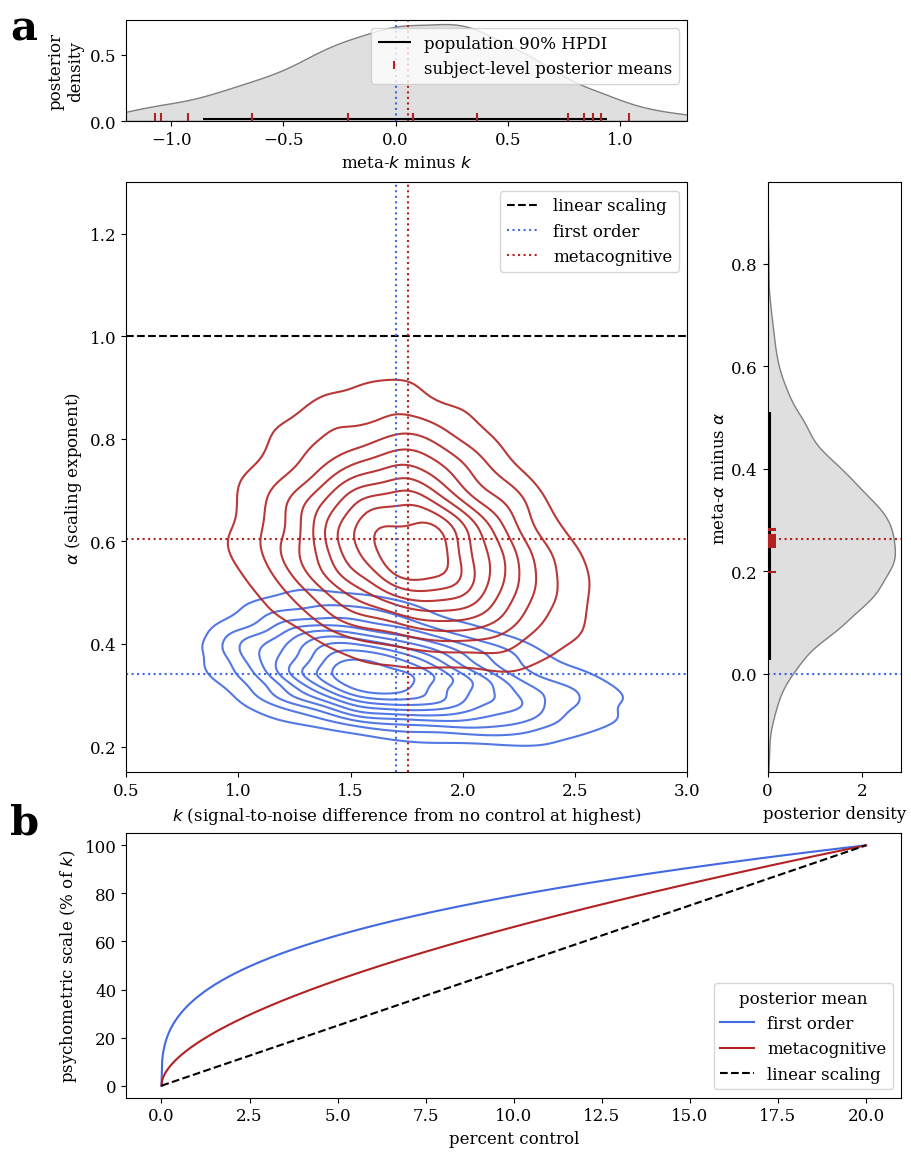

In [10]:
## visualize posterior of model parameters

f_color = 'royalblue'
m_color = 'firebrick'

fig = plt.figure(figsize = (10, 14))
gs = gridspec.GridSpec(7, 4, wspace = .6, hspace = .6)

ax = fig.add_subplot(gs[1:5, :-1])
kde_kwargs = dict(
    levels = np.linspace(.1, .9, 9),
    fill = False,
    alpha = .9, 
    ax = ax
)
sns.kdeplot(x = post.k.values, y = post.alpha.values, color = f_color, **kde_kwargs)
sns.kdeplot(x = post.meta_k.values, y = post.meta_alpha.values, color = m_color, **kde_kwargs)
ax.set_xlabel(r'$k$ (signal-to-noise difference from no control at highest)')
ax.set_ylabel(r'$\alpha$ (scaling exponent)')
ax.axhline(1, color = 'black', label = 'linear scaling', linestyle = '--')
ax.set_ylim(.15, 1.3)
ax.set_xlim(.5, 3)
ax.axhline(post.alpha.values.mean(), color = f_color, linestyle = 'dotted', label = 'first order')
ax.axhline(post.meta_alpha.values.mean(), color = m_color, linestyle = 'dotted', label = 'metacognitive')
ax.axvline(post.k.values.mean(), color = f_color, linestyle = 'dotted')
ax.axvline(post.meta_k.values.mean(), color = m_color, linestyle = 'dotted')
ax.legend()

delta_k_sub = post.meta_k_sub.values - post.k_sub.values
delta_k_sub = delta_k_sub.mean(1)
delta_alpha_sub = post.meta_alpha_sub.values - post.alpha_sub.values
delta_alpha_sub = delta_alpha_sub.mean(1)


ax = fig.add_subplot(gs[0, :-1])
delta = post.meta_k.values - post.k.values
sns.kdeplot(x = delta, color = 'grey', fill = True)
ax.set_xlim(.5 - post.k.mean(), 3 - post.k.mean())
ax.set_ylabel('posterior\ndensity')
ax.set_xlabel(r'meta-$k$ minus $k$')
ax.axvline(0, color = f_color, linestyle = 'dotted')
ax.axvline(delta.mean(), color = m_color, linestyle = 'dotted')
lower, upper = az.hdi(delta, hdi_prob = .9)
ax.hlines(.015, lower, upper, color = 'black', label = 'population 90% HPDI')
ax.scatter(delta_k_sub, np.zeros_like(delta_k_sub), marker = 2, zorder = 10, color = m_color,
           label = 'subject-level posterior means')
ax.legend()


ax = fig.add_subplot(gs[1:5, -1])
delta = post.meta_alpha.values - post.alpha.values
sns.kdeplot(y = delta, color = 'grey', fill = True)
ax.set_ylim(.15 - post.alpha.mean(), 1.3 - post.alpha.mean())
ax.axhline(0, color = f_color, linestyle = 'dotted')
ax.axhline(delta.mean(), color = m_color, linestyle = 'dotted')
lower, upper = az.hdi(delta, hdi_prob = .9)
ax.set_xlim(0, None)
ax.vlines(.045, lower, upper, color = 'black', label = '90% HPDI')
ax.set_xlabel('posterior density')
ax.set_ylabel(r'meta-$\alpha$ minus $\alpha$')
ax.yaxis.set_label_coords(-.3, .5)
ax.scatter(np.zeros_like(delta_alpha_sub), delta_alpha_sub, marker = 1, zorder = 10, color = m_color)

ax = fig.add_subplot(gs[5:, :])
first_order = lambda x: x**post.alpha.values * 100
meta = lambda x: x**post.meta_alpha.values * 100
diff = lambda x: meta(x) - first_order(x)
x = np.linspace(0, 1, 1000)
y_f = np.stack([first_order(x) for x in x])
y_m = np.stack([meta(x) for x in x])
x *= q_max # return x-axis to original scale
x *= 100 # and then convert from proportion to percentage
ax.plot(x, y_f.mean(1), color = f_color, label = 'first order')
ax.plot(x, y_m.mean(1), color = m_color, label = 'metacognitive')
ax.plot([0, 100*q_max], [0, 100], color = 'black', linestyle = '--', label = 'linear scaling')
ax.set_ylabel(r"psychometric scale (% of $k$)")
ax.set_xlabel('percent control')
ax.legend(title = 'posterior mean')

def add_label(ax, label, x_offset = -.15, y_offset = 0.):
    xmin, xmax = ax.get_xlim()
    xscale = xmax - xmin
    ymin, ymax = ax.get_ylim()
    yscale = ymax - ymin
    ax.text(
        xmin + x_offset*xscale, ymax + yscale*y_offset, 
        label, size = 30, weight = 'bold'
    )

add_label(ax, 'a', y_offset = 3)
add_label(ax, 'b')

if not os.path.exists('figures'):
    os.mkdir('figures')
plt.savefig(os.path.join('figures', 'control-scaling.jpeg'), dpi = 500, bbox_inches = 'tight')
plt.show()